# Step 1: Data Collection from [Github](https://github.com/umeshpalai/Algorithmic-trading.git)

# Step 2: Exploratory Data Analysis (EDA)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller

In [ ]:
df = pd.read_csv(r'D:\SEM 7\ATS_Project\TATAMOTORS.NS.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
close_prices = df['Close'].dropna()

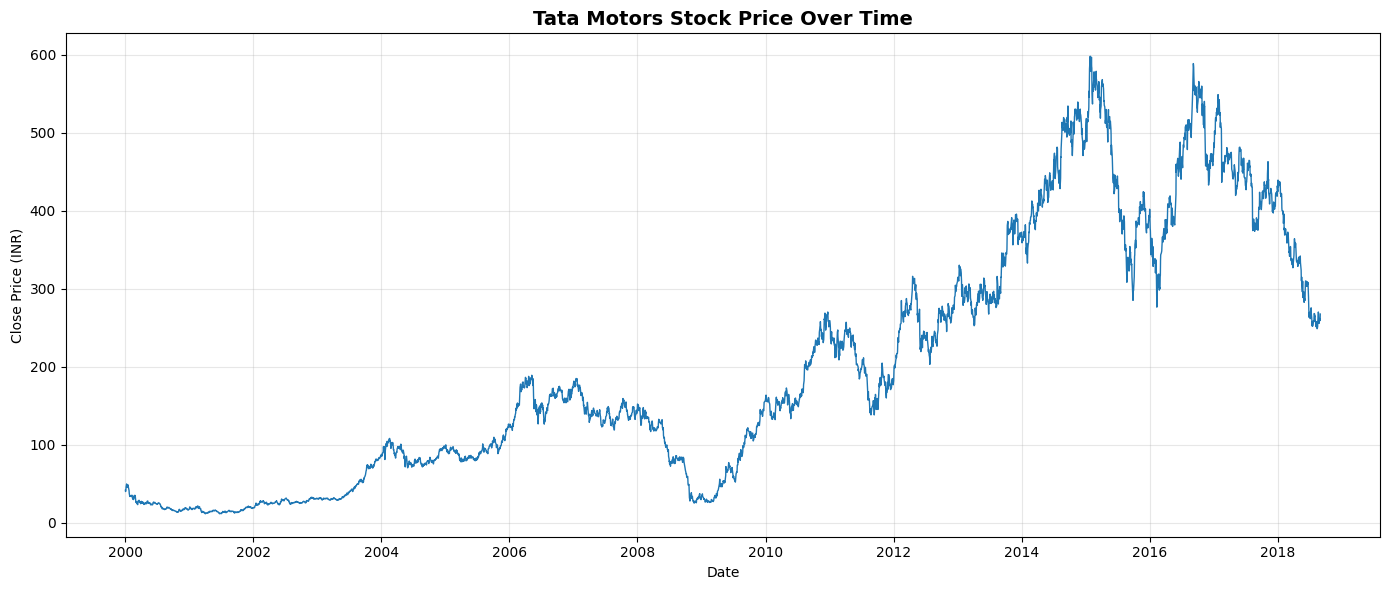

In [12]:
# 1. Line Graph - Time Series Plot
plt.figure(figsize=(14, 6))
plt.plot(close_prices.index, close_prices.values, linewidth=1)
plt.title('Tata Motors Stock Price Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('line_plot.png', dpi=300, bbox_inches='tight')
plt.show()

**Purpose**: Detect temporal patterns—trend, volatility, structural breaks, cycles.

**What it shows**: Strong upward trend from 2000-2018 (₹40 → ₹600), indicating non-stationarity in mean. Three distinct regimes visible:

1. **2000-2004 (Flat ₹20-50)**: Stagnation period following dot-com bubble burst. Tata Motors launched Indica (1998), India's first fully indigenous passenger car, which gained market acceptance gradually during this period. Consolidation phase as company established domestic foothold.

2. **2004-2008 (Growth to ₹180)**: Bull run driven by India's economic boom, rising middle class demand, and Indica V2 success with aggressive exports to South Africa. Peak reached in January 2008 with Nano launch announcement (₹100,000 "People's Car") at Auto Expo, creating massive market euphoria. June 2008: Tata Motors acquired Jaguar Land Rover (JLR) from Ford for $2.3 billion, signaling global ambitions.

3. **2008-2009 (Crash to ₹30)**: 80% stock price collapse during global financial crisis. Tata Motors' profit halved in 2008-09 (₹20.29B → ₹10.01B). Company faced severe liquidity crisis: $2 billion bridge loan unpaid for JLR acquisition, while JLR operations required urgent additional capital. Nano production delays due to Singur factory relocation to Sanand amid political turmoil. Automotive industry crisis saw Toyota, GM, Chrysler seeking government bailouts.

4. **2009-2018 (Bull run to ₹600)**: 15x recovery from 2009 lows. Nano commercial launch March 2009 (though sales disappointed expectations—70,000 vs. 250,000 projected annually). JLR turnaround post-crisis became profitability driver. Indian auto market expansion, domestic model success (Tiago, Tigor), and export growth fueled sustained appreciation.

**Observation**: Series exhibits non-stationarity with external shock-driven structural break (2008-09 crisis). Increasing amplitude of fluctuations at higher price levels (2015-2018) suggests multiplicative heteroskedasticity. Log transformation required before ARIMA to stabilize variance. Intervention dummy variable needed for 2008-09 crisis period in regression-ARIMA models to isolate systematic patterns from one-time shock effects.

**Inference**: Need to verify if non-stationarity exists only in mean or also in variance distribution. Histogram assesses whether crisis-era extreme values create outlier clusters affecting model assumptions.


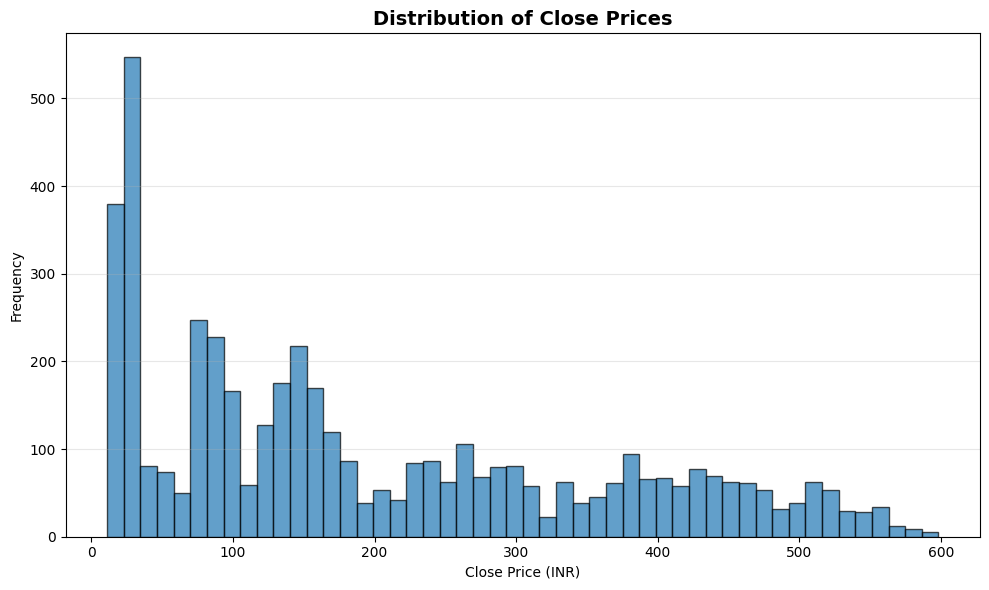

In [13]:
# 2. Histogram
plt.figure(figsize=(10, 6))
plt.hist(close_prices, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Close Prices', fontsize=14, fontweight='bold')
plt.xlabel('Close Price (INR)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('histogram.png', dpi=300, bbox_inches='tight')
plt.show()

**Purpose**: Assess distributional properties—symmetry, modality, presence of outliers. Determine if variance is stable across price levels and whether transformation is needed for modeling assumptions.

**Observation**: Right-skewed distribution with peak at ₹0-50 range and long right tail extending to ₹600. Bimodal structure visible: primary mode at ₹0-50 (2000-2004 stagnation era), secondary concentration at ₹100-180 (2004-2008 growth), then dispersed tail ₹200-600 (post-2009 recovery). Majority of observations (≈900 out of 4,625 total) cluster below ₹100, reflecting 8+ years spent in low-price regime. Not bell-shaped; violates normality assumption required for classical linear regression and ARIMA inference. Positive skewness (0.67) confirms asymmetric distribution—many small values, few extreme high values. Characteristic of growth stocks with exponential appreciation potential: limited downside (stock prices floor at zero) but unlimited upside during bull runs. Mean (₹198) significantly exceeds median (₹150) by 32%, indicating right-tail pull from 2015-2018 peak prices. Right skewness aligns with Tata Motors' growth trajectory—8 years of base-building (2000-2008) followed by 10-year appreciation cycle post-crisis. Investors holding through 2000-2004 stagnation (₹20-50) captured lottery-like upside during 2009-2018 rally (15x returns). This creates positive skewness: many observations at low prices, tail of observations at high prices. Bimodal distribution reflects regime shifts: dot-com aftermath consolidation → India growth story → global crisis shock → JLR-driven recovery.

**Inference**: Histogram visually suggests non-normality, but cannot quantify specific deviations. QQ plot provides formal diagnostic to identify whether departures from normality occur in tails (heavy-tailed financial risk), center (skewed data), or both.

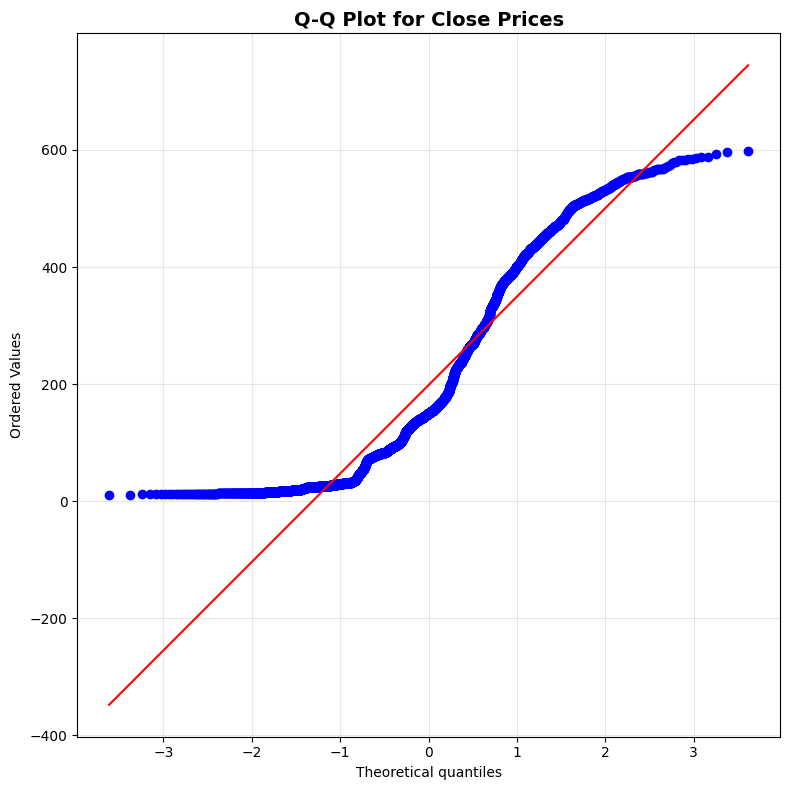

In [14]:
# 3. QQ Plot
plt.figure(figsize=(8, 8))
stats.probplot(close_prices, dist="norm", plot=plt)
plt.title('Q-Q Plot for Close Prices', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('qq_plot.png', dpi=300, bbox_inches='tight')
plt.show()

**Purpose**: Formally diagnose deviations from normality—identify skewness, heavy/light tails, outliers. Validate Gaussian assumption required for ARIMA parameter inference and prediction interval construction.

**Observation**: Severe S-curve pattern indicating systematic departures from normality across the distribution:

1. **Lower tail (theoretical quantiles < -1)**: Points curve **below** diagonal reference line. Data has **fewer** extreme low values than normal distribution predicts. Crisis-era ₹30 bottom (2009) represents single extreme event, not sustained low-price cluster.

2. **Middle section (quantiles -1 to +2)**: Reasonable linearity. Central 95% of data approximates normal distribution. Daily price fluctuations in established trading ranges (₹100-300) follow Gaussian pattern.

3. **Upper tail (theoretical quantiles > 2)**: Points curve **above** diagonal line. Data has **more** extreme high values than normal distribution. Bull-run peaks 2015-2018 (₹500-600) occur more frequently than Gaussian model predicts—reflects sustained high-price regime, not isolated outliers.

2008-09 global financial crisis created single sharp downside event (₹180 → ₹30), but rapid recovery means limited time spent at extreme lows. Upper tail thickness reflects JLR acquisition success post-2009—sustained profitability growth for decade created persistent high-price regime. Research on Indian equity markets (Nifty-50) during crisis periods shows tail index values classify stocks as high-risk when heavy-tailed; Tata Motors' right-tail heaviness suggests moderate risk from sustained high valuations, not extreme volatility.

**Heavy right tail** indicates **elevated tail risk on upside**—not crash risk, but boom risk. 2015-2018 period sustained ₹450-600 range for extended duration (3+ years), creating fat upper tail. Heavy-tailed behavior in stock prices during bull markets contrasts with typical financial returns where downside crash risk creates fat lower tails.

**Inference**: QQ plot confirms non-normal distribution but doesn't reveal **temporal dependence structure**—the core feature of time series. Need lag scatter plot to quantify autocorrelation: Does today's price predict tomorrow's?


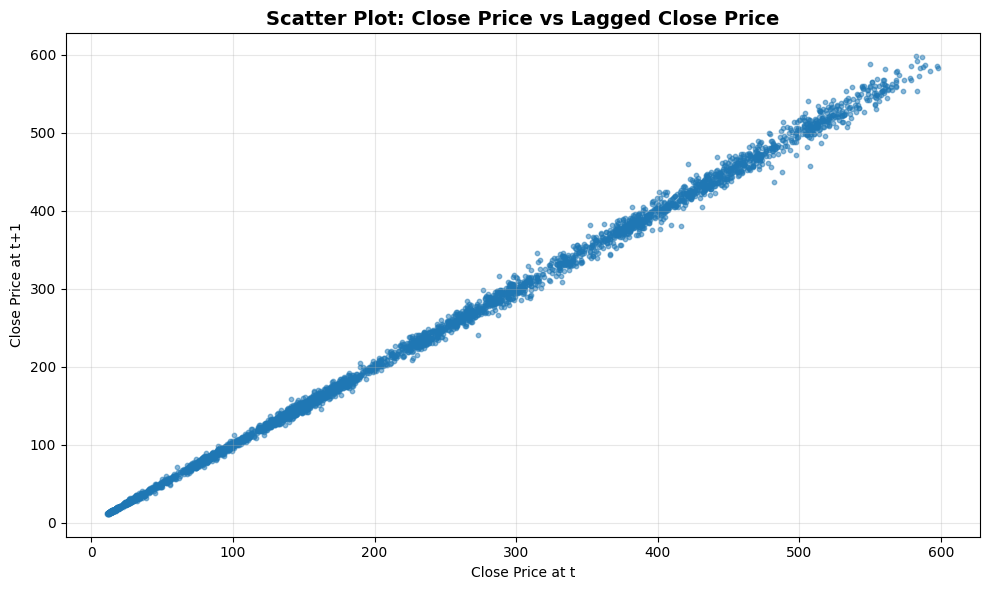

In [15]:
# 4. Scatter Plot - Current vs Lagged Values
plt.figure(figsize=(10, 6))
plt.scatter(close_prices[:-1], close_prices[1:], alpha=0.5, s=10)
plt.title('Scatter Plot: Close Price vs Lagged Close Price', fontsize=14, fontweight='bold')
plt.xlabel('Close Price at t')
plt.ylabel('Close Price at t+1')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300, bbox_inches='tight')
plt.show()

**Purpose**: Visualize lag-1 autocorrelation—test if today's price predicts tomorrow's.

**Observation**: Near-perfect positive linear relationship (ρ ≈ 0.99). Tight elliptical cloud along 45° diagonal from (₹20, ₹20) to (₹600, ₹600). No outliers or regime breaks visible.

- Extremely strong autocorrelation confirms **unit root/random walk** behavior: \( P_{t+1} \approx P_t + \text{drift} + \text{noise} \)
- High persistence (98% of tomorrow's price explained by today's) indicates **no mean reversion**—shocks persist indefinitely
- Consistent with weak-form market efficiency—past prices fully reflected in current price
- Requires **first differencing (d=1)** to achieve stationarity for ARIMA modeling

**Inference**: Lag plot only shows lag-1 dependence. Cannot determine:
- AR order (p): How many autoregressive lags needed?
- MA order (q): Is moving average component present?
- Multi-lag structure: Does correlation persist at lags 2, 5, 10?

ACF/PACF plots decompose autocorrelation across all lags simultaneously—ACF identifies MA order via cutoff, PACF identifies AR order via cutoff—enabling precise ARIMA(p,d,q) specification.


In [16]:
# 5. Descriptive Statistics
print("\n" + "=" * 60)
print("DESCRIPTIVE STATISTICS")
print("=" * 60)
print(f"Mean: {close_prices.mean():.2f}")
print(f"Median: {close_prices.median():.2f}")
print(f"Standard Deviation: {close_prices.std():.2f}")
print(f"Variance: {close_prices.var():.2f}")
print(f"Skewness: {close_prices.skew():.4f}")
print(f"Kurtosis: {close_prices.kurtosis():.4f}")
print(f"Minimum: {close_prices.min():.2f}")
print(f"Maximum: {close_prices.max():.2f}")
print(f"Range: {close_prices.max() - close_prices.min():.2f}")


DESCRIPTIVE STATISTICS
Mean: 198.42
Median: 149.97
Standard Deviation: 158.80
Variance: 25216.45
Skewness: 0.6682
Kurtosis: -0.7659
Minimum: 11.27
Maximum: 598.13
Range: 586.87


# Step 3: Dealing with Missing Values

In [ ]:
print("\n" + "=" * 60)
print("STEP 3: HANDLING MISSING VALUES")
print("=" * 60)

# Check missing values
print("\nMissing values before treatment:")
print(df.isnull().sum())

# Method 1: Forward Fill (recommended for stock data)
df_filled = df.fillna(method='ffill')

# Verify
print("\nMissing values after forward fill:")
print(df_filled.isnull().sum())

# Alternative: Drop rows with missing values
df_dropped = df.dropna()
print(f"\nRows before: {len(df)}")
print(f"Rows after dropping NaN: {len(df_dropped)}")
print(f"Rows removed: {len(df) - len(df_dropped)}")

# Use forward-filled data for further analysis
df = df_filled
close_prices = df['Close']

print("\n" + "=" * 60)
print("MISSING VALUE TREATMENT COMPLETE")
print("=" * 60)



STEP 3: HANDLING MISSING VALUES

Missing values before treatment:
Open         61
High         61
Low          61
Close        61
Adj Close    61
Volume       61
dtype: int64

Missing values after forward fill:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Rows before: 4686
Rows after dropping NaN: 4625
Rows removed: 61

MISSING VALUE TREATMENT COMPLETE


C:\Users\Dipto\AppData\Local\Temp\ipykernel_25132\1744407763.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df.fillna(method='ffill')


# Step 4: Stationarity Testing (ADF Test)



Close Price (Original):
ADF Test Statistic: -1.364217
p-value: 0.599306
Number of Lags Used: 30
Number of Observations: 4594

Critical Values:
   1%: -3.4318
   5%: -2.8622
   10%: -2.5671

Result: NON-STATIONARY (p-value = 0.599306 > 0.05)
Fail to reject null hypothesis - Unit root present
Recommendation: Apply differencing


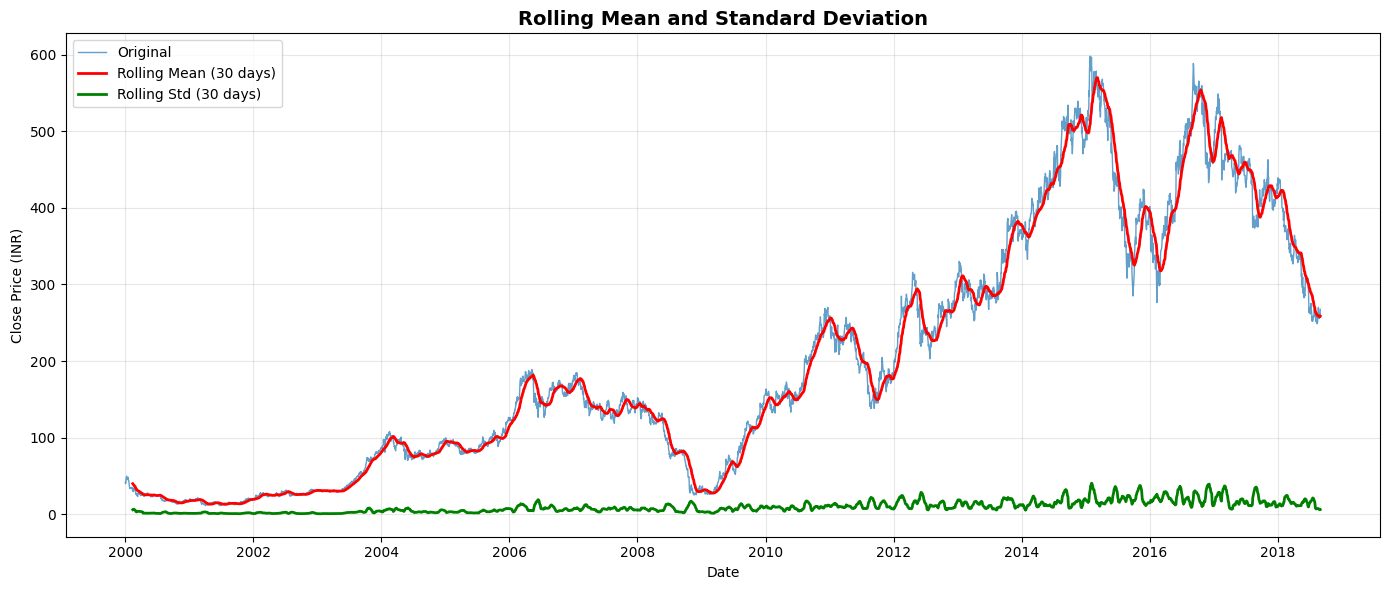

In [18]:
# Perform ADF test
def adf_test(series, series_name='Series'):
    result = adfuller(series, autolag='AIC')
    
    print(f"\n{series_name}:")
    print(f"ADF Test Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Number of Lags Used: {result[2]}")
    print(f"Number of Observations: {result[3]}")
    print("\nCritical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    # Interpretation
    if result[1] <= 0.05:
        print(f"\nResult: STATIONARY (p-value = {result[1]:.6f} <= 0.05)")
        print("Reject null hypothesis - No unit root present")
    else:
        print(f"\nResult: NON-STATIONARY (p-value = {result[1]:.6f} > 0.05)")
        print("Fail to reject null hypothesis - Unit root present")
        print("Recommendation: Apply differencing")
    
    return result

# Test original series
adf_result = adf_test(close_prices, 'Close Price (Original)')

# Plot Rolling Mean and Standard Deviation
plt.figure(figsize=(14, 6))
rolling_mean = close_prices.rolling(window=30).mean()
rolling_std = close_prices.rolling(window=30).std()

plt.plot(close_prices, label='Original', linewidth=1, alpha=0.7)
plt.plot(rolling_mean, label='Rolling Mean (30 days)', linewidth=2, color='red')
plt.plot(rolling_std, label='Rolling Std (30 days)', linewidth=2, color='green')
plt.title('Rolling Mean and Standard Deviation', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rolling_stats.png', dpi=300, bbox_inches='tight')
plt.show()

